# Explaining image data with Lime in AIX360

This example uses an image dataset and model acquired from https://www.kaggle.com/choiseokhyeon/bts-crop2. It is based on a korean group of seven members and tries to classify the images according to those. 
Sources used are:
- https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Faces%20and%20GradBoost.ipynb
- https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import csv
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.models import ResNet

## Load and prepare image  

(-0.5, 829.5, 851.5, -0.5)

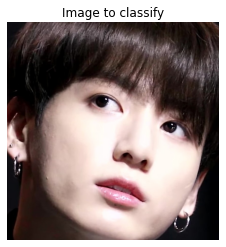

In [2]:
def get_img(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_img('images/jk.jpeg')
plt.title("Image to classify")
plt.imshow(img)
plt.axis("off")

Converting image to pytorch tensor.

In [3]:
def transform_img():
    trans = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(112),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])
    return trans

def get_input_tensors(img):
    transf = transform_img()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

## Setting up classification model

Classification classes taken from the original model.

In [4]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride
       
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
       
        out = self.dropout(out)
       
       
        if self.downsample is not None:
            residual = self.downsample(x)

           
        out += residual
        out = self.relu(out)

        return out


def se_resnet18(num_classes=7):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model

### Load pretrained model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load('save_model/ckpt.pth') # Loading pretrained model
model = se_resnet18() 
model = model.to(device)
model.load_state_dict(checkpoint['net'])

classes=["JM", "JN", "JH", "JK", "RM", "VV", "SG"]

## Classify image

In [6]:
img_t = get_input_tensors(img) # Convert to tensor
model.eval()
logits = model(img_t) # Classify image using model

# Display probabilities of each class for specific image
probs = F.softmax(logits, dim=1)
probs7 = probs.topk(7)
tuple((p,c, classes[c]) for p, c in zip(probs7[0][0].detach().numpy(), probs7[1][0].detach().numpy())) 

((0.8042391, 3, 'JK'),
 (0.09404108, 6, 'SG'),
 (0.073149815, 1, 'JN'),
 (0.014489797, 5, 'VV'),
 (0.010747851, 0, 'JM'),
 (0.0033157119, 2, 'JH'),
 (1.6588434e-05, 4, 'RM'))

## Preparing image for Lime

In [7]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(112),
        transforms.CenterCrop(112)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

## Define classification function

In [8]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax() # displays predicted class with highest prbability

3

## Explaining classification using Lime

In [9]:
from aix360.algorithms.lime import LimeImageExplainer


explainer = LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=7, 
                                         hide_color=0, 
                                         num_samples=222) # number of images that will be sent to classification function


### Using mask to visualize prediction

(-0.5, 111.5, 111.5, -0.5)

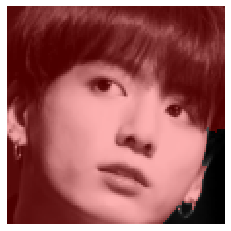

In [10]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Set up mask for positive regions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# Display mask
plt.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
plt.axis("off")

(-0.5, 111.5, 111.5, -0.5)

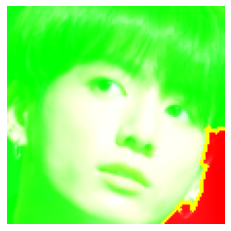

In [11]:
# Set up different type of mask for positive and negative regions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)

plt.imshow(img_boundry)
plt.axis("off")

### Applying mask to every class

Reading and loading csv file to load representative image of each class.

In [12]:
results = [] # List with all data
names = [] # List with class names 

with open("results.csv") as csvfile: # csv file was created from given pickle file
    reader = csv.reader(csvfile) 
    for row in reader: # each row of the csv file is appended to list
        results.append(row)

for i in range (1,2221):
    names.append(results[i][2])
    
# print(results[1:5])
# print(names[:5])

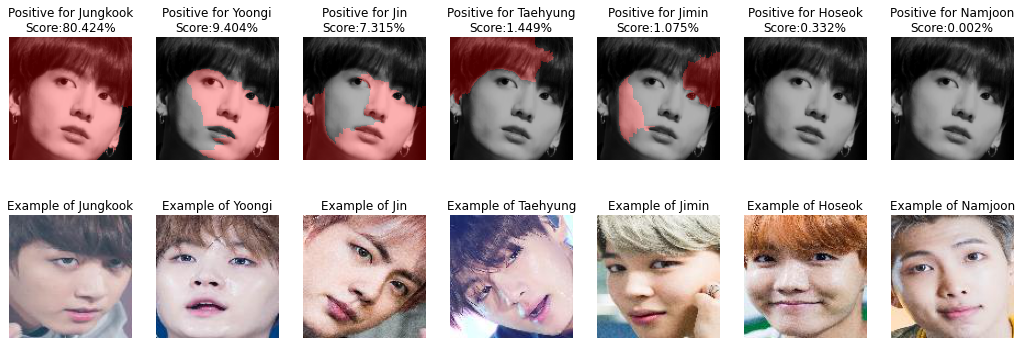

In [13]:
# Display name of member instead of class name
def name(label):
    name = ""
    if label == 'JM':
        name = "Jimin"
    elif label == 'JN':
        name = "Jin"
    elif label == 'JH':
        name = "Hoseok"
    elif label == 'JK':
        name = "Jungkook"
    elif label == 'RM':
        name = "Namjoon"
    elif label == 'VV':
        name = "Taehyung"
    else:
        name = "Yoongi"
    return name

# Set up image grid
fig, m_axs = plt.subplots(2,7, figsize = (18,6))

# Display mask for every class
for i, j,(c_ax, gt_ax) in zip(explanation.top_labels, [0,1,2,3,4,5,6], m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    
    # Display potential class name and probability for specific image
    c_ax.set_title('Positive for {}\nScore:{:2.3f}%'.format(name(classes[probs7[1][0][j].detach().numpy()]), 100*probs7[0][0][j].detach().numpy()))
    c_ax.axis('off')
    
    # Excluding falsely classified images 
    for x in range(0,2221):
        if (results[x][2]==classes[probs7[1][0][j].detach().numpy()] 
            and results[x][1] != "20092.jpg" 
            and results[x][1] != "20655.jpg"
            and results[x][1] != "20659.jpg"
            and results[x][1] != "20085.jpg"):
            face_id = results[x][1]
            break

    # Displaying images and corresponding class/member name
    gt_ax.imshow(get_img('images/{}'.format(face_id)))
    gt_ax.set_title('Example of {}'.format(name(classes[probs7[1][0][j].detach().numpy()])))
    gt_ax.axis('off')
